In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from tensorflow.keras.datasets import fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images.shape

(60000, 28, 28)

In [3]:
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential

model = Sequential([
    Flatten(input_shape=(28,28)),
    Dense(100, activation='relu'),
    Dense(30, activation='relu'),
    Dense(10, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                310       
Total params: 81,840
Trainable params: 81,840
Non-trainable params: 0
_________________________________________________________________


### categorical crossentropy를 적용하려면 target값은 반드시 ```one hot encoding``` 해야된다
one hot encoding 안할거면 sparse_categorical_crossentropy 사용

In [4]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy

model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [5]:
from tensorflow.keras.utils import to_categorical

train_oh_labels = to_categorical(train_labels)
test_oh_labels = to_categorical(test_labels)

history = model.fit(x=train_images, y=train_oh_labels, batch_size=32, epochs=20, verbose=1)
print(history.history['loss'])
print(history.history['accuracy'])

Epoch 1/20
1875/1875 [==============================] - 2s 957us/step - loss: 4.2487 - accuracy: 0.3506
Epoch 2/20
1875/1875 [==============================] - 2s 982us/step - loss: 0.9003 - accuracy: 0.6555
Epoch 3/20
1875/1875 [==============================] - 2s 921us/step - loss: 0.7486 - accuracy: 0.7050
Epoch 4/20
1875/1875 [==============================] - 2s 925us/step - loss: 0.6552 - accuracy: 0.7358
Epoch 5/20
1875/1875 [==============================] - 2s 922us/step - loss: 0.5785 - accuracy: 0.7716
Epoch 6/20
1875/1875 [==============================] - 2s 959us/step - loss: 0.5234 - accuracy: 0.8109
Epoch 7/20
1875/1875 [==============================] - 2s 969us/step - loss: 0.4763 - accuracy: 0.8412
Epoch 8/20
1875/1875 [==============================] - 2s 930us/step - loss: 0.4511 - accuracy: 0.8508
Epoch 9/20
1875/1875 [==============================] - 2s 928us/step - loss: 0.4320 - accuracy: 0.8578
Epoch 10/20
1875/1875 [==============================] - 2s 923u

In [6]:
pred_proba = model.predict(test_images)
print(pred_proba.shape)

(10000, 10)


전체 데이터셋을 predict할 경우 위의 cell처럼 n개의 28 * 28개의 데이터를 넣으면 되는데 하나의 이미지만 predict 시킬 때는 차원을 바꿔줘야한다

```(10000,28,28)```형태로 3차원이어야 하는데 test_images[0]으로 하나의 이미지만 불러오면 ```(28,28)``` 이런식이기 때문

```np.expand_dims```을 이용하여 차원을 늘려준다( []를 한겹 더 씌워준다고 생각하면됨)

In [7]:
test_images[0].shape

(28, 28)

predict하여 각각의 class값에 대해 softmax 값을 구함

np.argmax로 최대값을 고른다

np.squeeze를 하면 predict를 할때 expand_dims로 차원을 늘린것을 다시 축소시켜준다

In [8]:
pred_proba = model.predict(np.expand_dims(test_images[0], axis=0))
print('softmax output : ', pred_proba)
pred = np.argmax(np.squeeze(pred_proba))
print('predicted class value : ', pred)

softmax output :  [[5.2819957e-36 0.0000000e+00 0.0000000e+00 3.1718872e-32 0.0000000e+00
  2.9044633e-03 2.0338887e-38 6.2157996e-02 2.3677951e-20 9.3493748e-01]]
predicted class value :  9


In [9]:
model.evaluate(test_images, test_oh_labels, batch_size=64)

157/157 [==============================] - 0s 712us/step - loss: 0.4810 - accuracy: 0.8502


[0.4810119569301605, 0.8501999974250793]

### 검증 데이터 셋 이용하기

In [14]:
from sklearn.model_selection import train_test_split

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
tr_images, val_images, tr_labels, val_labels = train_test_split(train_images, train_labels,
                                                               test_size=0.15,
                                                               random_state=23)

print(tr_images.shape, val_images.shape)

tr_oh_labels = to_categorical(tr_labels)
val_oh_labels = to_categorical(val_labels)

print(tr_oh_labels.shape, val_oh_labels.shape)

(51000, 28, 28) (9000, 28, 28)
(51000, 10) (9000, 10)


In [16]:
model = Sequential([
    Flatten(input_shape=(28,28)),
    Dense(100, activation='relu'),
    Dense(30, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=32, epochs=20, verbose=1,
                   validation_data=(val_images, val_oh_labels))

Epoch 1/20
1594/1594 [==============================] - 2s 1ms/step - loss: 5.6233 - accuracy: 0.4532 - val_loss: 1.2053 - val_accuracy: 0.5208
Epoch 2/20
1594/1594 [==============================] - 2s 1ms/step - loss: 1.1223 - accuracy: 0.5387 - val_loss: 1.0672 - val_accuracy: 0.5538
Epoch 3/20
1594/1594 [==============================] - 2s 1ms/step - loss: 0.9733 - accuracy: 0.5944 - val_loss: 0.8742 - val_accuracy: 0.6634
Epoch 4/20
1594/1594 [==============================] - 2s 1ms/step - loss: 0.8217 - accuracy: 0.6797 - val_loss: 0.7072 - val_accuracy: 0.7218
Epoch 5/20
1594/1594 [==============================] - 2s 1ms/step - loss: 0.6600 - accuracy: 0.7341 - val_loss: 0.5997 - val_accuracy: 0.7564
Epoch 6/20
1594/1594 [==============================] - 2s 1ms/step - loss: 0.5998 - accuracy: 0.7541 - val_loss: 0.6078 - val_accuracy: 0.7643
Epoch 7/20
1594/1594 [==============================] - 2s 1ms/step - loss: 0.5865 - accuracy: 0.7561 - val_loss: 0.5914 - val_accuracy:

### 훈련데이터와 검증데이터 정확도 비교
- plt.show()하면 범주가 나오지않는다
- plt.legend()를 해주면 나온다

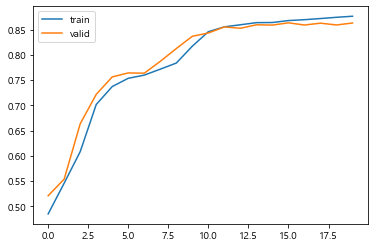

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.legend()

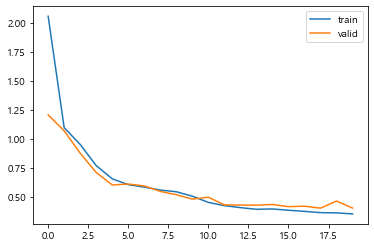

In [23]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()